# Import Price Data From Kraken API:

In [755]:
import krakenex 
from pykrakenapi import KrakenAPI
import sys
import time
import urllib.request
import json
import requests
import pandas as pd
import numpy as np 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA

In [756]:
api = krakenex.API()
k = KrakenAPI(api)

In [757]:
ohlc = k.get_ohlc_data("BTCUSD")
print(ohlc)

(                           time     open     high      low    close     vwap  \
dtime                                                                          
2021-06-08 08:08:00  1623139680  33235.1  33235.1  33167.2  33173.1  33213.1   
2021-06-08 08:07:00  1623139620  33271.7  33286.7  33226.7  33234.4  33259.1   
2021-06-08 08:06:00  1623139560  33258.1  33306.4  33220.4  33271.7  33259.1   
2021-06-08 08:05:00  1623139500  33229.1  33305.1  33200.0  33258.1  33255.9   
2021-06-08 08:04:00  1623139440  33174.4  33223.3  33156.8  33223.3  33195.3   
...                         ...      ...      ...      ...      ...      ...   
2021-06-07 20:13:00  1623096780  35550.0  35602.0  35550.0  35602.0  35569.9   
2021-06-07 20:12:00  1623096720  35550.0  35550.0  35533.0  35550.0  35549.1   
2021-06-07 20:11:00  1623096660  35551.8  35551.8  35547.3  35550.0  35549.7   
2021-06-07 20:10:00  1623096600  35569.1  35569.1  35546.9  35546.9  35562.1   
2021-06-07 20:09:00  1623096540  35617.

In [758]:
def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200: 
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)
    return data

In [759]:
btc = fetch_OHLC_data(symbol="BTC/USD", timeframe="1440")
btc = btc.drop(columns=["unix", "open", "high", "low", "volume_from"])
btc = btc.set_index("date")
btc['close'] = btc['close'].astype(float)
btc['returns'] = btc.close.pct_change()
btc['change_in_price'] = btc['returns']
btc.change_in_price[btc.change_in_price > 0] = 1
btc.change_in_price[btc.change_in_price <= 0] = 0
btc.dropna(inplace=True)
btc['change_in_price'] = btc['change_in_price'].astype(int)
btc

C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,close,vwap,volume,tradecount,returns,change_in_price
date,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1
...,...,...,...,...,...,...
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1


# Generate Quantitative Trading Signals:

In [760]:
def generate_signals(btc):
    """Generates trading signals for a given dataset."""
    # Grab just the `date` and `close` from the IEX dataset
    signals_df = btc.copy()
    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long moving averages (50 and 100 days, respectively)
    signals_df["SMA50"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA100"] = signals_df["close"].rolling(window=long_window).mean()

    signals_df["Signal"] = 0.0
    # Generate the trading signal 0 or 1,
    # where 0 is when the SMA50 is under the SMA100, and
    # where 1 is when the SMA50 is higher (or crosses over) the SMA100
    signals_df["Signal"][short_window:] = np.where(
        signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:],
        1.0,
        0.0,
    )
    # Calculate the points in time at which a position should be taken, 1 or -1
    signals_df["Entry/Exit"] = signals_df["Signal"].diff()
    return signals_df

In [761]:
mov_avg = generate_signals(btc)
mov_avg.tail()

C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit
date,,,,,,,,,,
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0
2021-06-08,33215.6,33043.6,3530.17644349,25149,-0.011076,0,46325.474,51417.769,0.0,0.0


In [833]:
bollinger_window = 20

# Calculate rolling mean and standard deviation
all_sig = mov_avg.copy()
all_sig['bollinger_mid_band'] = mov_avg['close'].rolling(window=bollinger_window).mean()
all_sig['bollinger_std'] = mov_avg['close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
all_sig['bollinger_upper_band']  = all_sig['bollinger_mid_band'] + (all_sig['bollinger_std'] * 1)
all_sig['bollinger_lower_band']  = all_sig['bollinger_mid_band'] - (all_sig['bollinger_std'] * 1)

# Calculate bollinger band trading signal
all_sig['bollinger_long'] = np.where(all_sig['close'] < all_sig['bollinger_lower_band'], 1.0, 0.0)
all_sig['bollinger_short'] = np.where(all_sig['close'] > all_sig['bollinger_upper_band'], -1.0, 0.0)
all_sig['bollinger_signal'] = all_sig['bollinger_long'] + all_sig['bollinger_short']
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
date,,,,,,,,,,,,,,,,,
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873,0.0,0.0,0.0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874,0.0,0.0,0.0
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,37018.655,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0
2021-06-08,33215.6,33043.6,3530.17644349,25149,-0.011076,0,46325.474,51417.769,0.0,0.0,36842.320,1987.104115,38829.424115,34855.215885,1.0,0.0,1.0


In [763]:
from ta.momentum import RSIIndicator

In [837]:
rsi_14 = RSIIndicator(close = all_sig.close, window = 14)
all_sig["RSI"] = rsi_14.rsi()
all_sig["RSI_long"] = np.where(all_sig["RSI"] < 30, 1.0, 0.0)
all_sig["RSI_short"] = np.where(all_sig["RSI"] > 70, -1.0, 0.0)
all_sig["RSI_signal"] = all_sig["RSI_long"] + all_sig["RSI_short"]
all_sig.tail()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,RSI,RSI_long,RSI_short,RSI_signal
date,,,,,,,,,,,,,,,,,,,,,
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0,...,3020.097127,41439.662127,35399.467873,0.0,0.0,0.0,39.703001,0.0,0.0,0.0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0,...,2412.901126,40285.076126,35459.273874,0.0,0.0,0.0,37.564257,0.0,0.0,0.0
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0,...,2047.953661,39531.988661,35436.081339,0.0,0.0,0.0,38.258192,0.0,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0,...,1795.580802,38814.235802,35223.074198,1.0,0.0,1.0,34.667528,0.0,0.0,0.0
2021-06-08,33215.6,33043.6,3530.17644349,25149,-0.011076,0,46325.474,51417.769,0.0,0.0,...,1987.104115,38829.424115,34855.215885,1.0,0.0,1.0,34.085362,0.0,0.0,0.0


In [841]:
# Generate the trading signal 0 or 1,
# where 0 is when the close is under the VWAP, and
# where 1 is when the close is higher (or crosses over) the VWAP
all_sig["VWAP_long"] = np.where(all_sig["close"] < all_sig["vwap"])
all_sig["VWAP_short"] = np.where(all_sig["close"] > all_sig["vwap"], 1.0)
all_sig["VWAP_signal"] = all_sig["VWAP_short"] + all_sig["VWAP_long"]


TypeError: '<' not supported between instances of 'float' and 'str'

# PCA Analysis 

In [765]:
#all_sig_pca = all_sig.dropna()

In [766]:
#sig_scaled = StandardScaler().fit_transform(all_sig_pca)
#all_sig_scaled = pd.DataFrame(data=sig_scaled)
#all_sig_scaled = all_sig

In [767]:
#pca = PCA(n_components=3)
#sig_pca = pca.fit_transform(sig_scaled)
#sig_df = pd.DataFrame(data=sig_pca, columns=["pc1", "pc2", "pc3"])
#sig_df

In [768]:
#pca.explained_variance_ratio_

# Random Forest PCA

In [769]:
#avg_chng = all_sig["returns"]

In [770]:
#X = sig_df.copy()
#X.head()

In [771]:
#y=all_sig['returns'].values.reshape(-1,1)
#y=y[99:]
#y[:5]

# Random Forest With Raw Variables

In [772]:
X = all_sig.copy()
X.dropna(inplace=True)
X.drop(columns=['close','returns','change_in_price'], inplace=True)
X.head()

,vwap,volume,tradecount,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI
date,,,,,,,,,,,,
2019-09-28,8171.3,3824.92774834,11962,10103.012,10512.054,0.0,0.0,9711.105,862.088116,10573.193116,8849.016884,24.042450
2019-09-29,8040.9,4937.63306462,13621,10038.380,10490.393,0.0,0.0,9598.035,924.802142,10522.837142,8673.232858,22.690434
2019-09-30,8051.4,7532.44669163,29502,9974.046,10466.855,0.0,0.0,9508.810,959.804138,10468.614138,8549.005862,29.526027
2019-10-01,8379.4,7856.25020541,31716,9912.822,10441.944,0.0,0.0,9416.925,981.823851,10398.748851,8435.101149,29.863973
2019-10-02,8262.6,3884.72475803,12206,9863.328,10415.561,0.0,0.0,9315.040,977.974862,10293.014862,8337.065138,31.478126


In [818]:
y=all_sig['change_in_price'].values.reshape(-1,1)
y=y[99:]
y[:5]

array([[1],
       [0],
       [1],
       [1],
       [1]])

In [819]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [820]:
scaler = StandardScaler()

In [821]:
X_scaler = scaler.fit(X_train)

In [822]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [823]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [824]:
rf_model = rf_model.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [825]:
predictions = rf_model.predict(X_test_scaled)

In [826]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

acc_score = accuracy_score(y_test, predictions)

In [827]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,29,50
Actual 1,23,53


Accuracy Score : 0.5290322580645161
Classification Report
              precision    recall  f1-score   support

           0       0.56      0.37      0.44        79
           1       0.51      0.70      0.59        76

    accuracy                           0.53       155
   macro avg       0.54      0.53      0.52       155
weighted avg       0.54      0.53      0.52       155



In [828]:
importances = rf_model.feature_importances_

In [829]:
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.16803980838401625, 'RSI'),
 (0.11734653923287426, 'volume'),
 (0.11063459989762292, 'tradecount'),
 (0.09821182181974084, 'bollinger_std'),
 (0.09403980697584138, 'vwap'),
 (0.08513199902923142, 'bollinger_upper_band'),
 (0.08207593296565513, 'bollinger_lower_band'),
 (0.08169803487374154, 'SMA100'),
 (0.07780986503604843, 'bollinger_mid_band'),
 (0.07676079066939293, 'SMA50')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

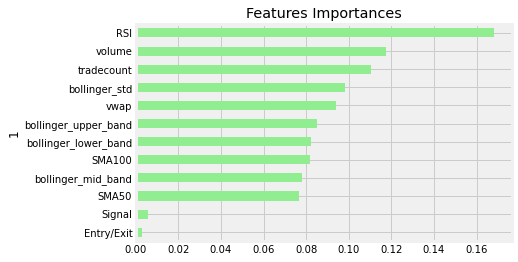

In [830]:
importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances.set_index(importances[1], inplace=True)
importances.drop(columns=1, inplace=True)
importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Random Forest Training for Algo Trading

##### From day 3 Algo Trading Module

In [565]:
all_sig

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI
date,,,,,,,,,,,,,,,
2019-06-20,9534.3,9402.8,6475.26400109,22100,0.027724,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,39196.6,38554.9,5230.07628658,36795,0.043426,1,48760.844,52013.217,0.0,0.0,38915.735,3521.755172,42437.490172,35393.979828,42.190419
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873,39.554589
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874,38.155382


In [566]:
x_var_list = ['Signal', 'Entry/Exit']
all_sig[x_var_list]

,Signal,Entry/Exit
date,,
2019-06-20,0.0,NaN
2019-06-21,0.0,0.0
2019-06-22,0.0,0.0
2019-06-23,0.0,0.0
2019-06-24,0.0,0.0
...,...,...
2021-06-03,0.0,0.0
2021-06-04,0.0,0.0
2021-06-05,0.0,0.0


In [567]:
all_sig.dropna(subset=x_var_list, inplace=True)
all_sig.dropna(subset=['returns'],inplace=True)
all_sig = all_sig.replace([np.inf, -np.inf], np.nan)
all_sig.head()

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI
date,,,,,,,,,,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [568]:
all_sig['Positive Return'] = np.where(all_sig['returns'] > 0, 1.0, 0.0)
all_sig

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI,Positive Return
date,,,,,,,,,,,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,39196.6,38554.9,5230.07628658,36795,0.043426,1,48760.844,52013.217,0.0,0.0,38915.735,3521.755172,42437.490172,35393.979828,42.190419,1.0
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873,39.554589,0.0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874,38.155382,0.0


In [569]:
training_start = all_sig.index.min().strftime(format='%Y-%m-%d')
training_end = '2019-12-31'
testing_start = '2019-06-21'
testing_end = all_sig.index.max().strftime(format='%Y-%m-%d')
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-06-21
Training End: 2019-12-31
Testing Start: 2019-06-21
Testing End: 2021-06-07


In [570]:
# Construct the X_train and y_train datasets
X_train = all_sig[x_var_list][training_start:training_end]
y_train = all_sig['Positive Return'][training_start:training_end]

X_train.tail()

,Signal,Entry/Exit
date,,
2019-12-27,0.0,0.0
2019-12-28,0.0,0.0
2019-12-29,0.0,0.0
2019-12-30,0.0,0.0
2019-12-31,0.0,0.0


In [571]:
y_train.tail()

date
2019-12-27    1.0
2019-12-28    1.0
2019-12-29    1.0
2019-12-30    0.0
2019-12-31    0.0
Name: Positive Return, dtype: float64

In [572]:
# Construct the X test and y test datasets
X_test = all_sig[x_var_list][testing_start:testing_end]
y_test = all_sig['Positive Return'][testing_start:testing_end]

X_test.tail()

,Signal,Entry/Exit
date,,
2021-06-03,0.0,0.0
2021-06-04,0.0,0.0
2021-06-05,0.0,0.0
2021-06-06,0.0,0.0
2021-06-07,0.0,0.0


In [573]:
y_test.tail()

date
2021-06-03    1.0
2021-06-04    0.0
2021-06-05    0.0
2021-06-06    1.0
2021-06-07    0.0
Name: Positive Return, dtype: float64

In [574]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [575]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
date,,
2019-06-21,1.0,0.0
2019-06-22,1.0,0.0
2019-06-23,1.0,0.0
2019-06-24,1.0,0.0
2019-06-25,1.0,0.0
...,...,...
2021-06-03,1.0,0.0
2021-06-04,0.0,0.0
2021-06-05,0.0,0.0


In [576]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

### Plot Cumulative Returns:

In [594]:
initial_capital = 1000000

In [ ]:
cumulative_return_capital = initial_capital * (1 + (result['Return'] * results['Predicted Value']


# Deep Learning Price Prediction: 

In [577]:
import numpy as np
import pandas as pd
import hvplot.pandas

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [578]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [579]:
all_sig = all_sig.drop(columns=["change_in_price", "returns"])
all_sig

,close,vwap,volume,tradecount,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI,Positive Return
date,,,,,,,,,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-22,10663.8,10665.9,12842.48586265,54100,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-23,10814.1,10837.5,5943.46891708,34849,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-24,11020.6,10843.5,5457.41272587,26308,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2019-06-25,11765.1,11340.2,11623.88144358,40223,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,39196.6,38554.9,5230.07628658,36795,48760.844,52013.217,0.0,0.0,38915.735,3521.755172,42437.490172,35393.979828,42.190419,1.0
2021-06-04,36847.7,37066.4,4991.51744280,46978,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873,39.554589,0.0
2021-06-05,35534.6,36066.4,5532.75325986,39833,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874,38.155382,0.0


In [580]:
def window_data(all_sig, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(all_sig) - window - 1):
        features = all_sig.iloc[i:(i + window), feature_col_number]
        target = all_sig.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [581]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(all_sig, window_size, feature_column, target_column)

In [582]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [583]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [584]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [585]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [586]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))

In [587]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [588]:
# Summarize the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10, 30)            3840      
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 30)            7320      
_________________________________________________________________
dropout_22 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_23 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [589]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
494/494 [==============================] - 14s 11ms/step - loss: 0.0538
Epoch 2/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0085
Epoch 3/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0075
Epoch 4/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 5/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0103
Epoch 6/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0093
Epoch 7/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0078
Epoch 8/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0083
Epoch 9/10
494/494 [==============================] - 5s 11ms/step - loss: 0.0077
Epoch 10/10
494/494 [==============================] - 5s 10ms/step - loss: 0.0076


In [590]:
# Evaluate the model
model.evaluate(X_test, y_test)

7/7 [==============================] - 2s 3ms/step - loss: 0.1358


0.13581505417823792

In [591]:
# Make some predictions
predicted = model.predict(X_test)

In [592]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [593]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

ValueError: Shape of passed values is (213, 2), indices imply (200, 2)

In [ ]:
# Plot the real vs predicted values as a line chart
stocks.plot()

# Attempt Sentiment Analysis Using Twitter: 

In [ ]:
import tweepy 
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
API_KEY="ixfnArRC0LrqGw9oMsKWaeeHH"
API_SECRET_KEY="bavWCrmk1pGMFTyUkScWgLwtbGt7TYbTqzIFBGUc3H4xAgIn33"
BEARER_TOKEN="1049318615261097984-2TXX3rME99h28i7ZuE6LmirwUtW0KW"
BEARER_TOKEN_SECRET="EznHh57YvAkj299l4GdqtNsnfQ7Ge9UZYPMPROkUA2ukC"
AZURE_KEY1="934412a2f06d4a37bf1fc3cbb513a944"
AZURE_KEY2="52cf1c0ec04d4fb085c583ea5680d646"

In [52]:
consumerKey = API_KEY
consumerSecret = API_SECRET_KEY
accessToken = BEARER_TOKEN
accessTokenSecret = BEARER_TOKEN_SECRET

In [53]:
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

In [54]:
authenticate.set_access_token(accessToken, accessTokenSecret)

In [55]:
api = tweepy.API(authenticate, wait_on_rate_limit=True)

In [56]:
#save the id of the oldest tweet less one
username = "elonmusk"

alltweets = []	
new_tweets = api.user_timeline(screen_name = username,count=200)

#save most recent tweets
alltweets.extend(new_tweets)

#save the id of the oldest tweet less one

oldest = alltweets[-1].id - 1

posts = api.user_timeline(screen_name = username, count = 200, max_id=oldest, tweet_mode="extended")

In [81]:
type(posts[0])

tweepy.models.Status

In [82]:
print("Show the 5 recent tweets: \n ")
i = 1
for tweet in posts[0:5]:
  print(str(i) + ')' +  tweet.full_text + "\n")
  i = i+1

Show the 5 recent tweets: 
 
1)@JRNYcrypto Needs laser eyes too

2)@JRNYcrypto 🤣🤣

3)#Bitcoin 💔 https://t.co/lNnEfMdtJf

4)@engineers_feed 🤣🤣

5)RT @SpaceX: Webcast of Falcon 9 launch of Dragon is now live → https://t.co/bJFjLCzWdK https://t.co/DqmJojsOMO



In [83]:
for status in api.user_timeline():
    print(status.id)

In [60]:
df = pd.DataFrame([tweet.full_text for tweet in posts], columns = ['Tweets'])

In [61]:
df.head()

,Tweets
0,@JRNYcrypto Needs laser eyes too
1,@JRNYcrypto 🤣🤣
2,#Bitcoin 💔 https://t.co/lNnEfMdtJf
3,@engineers_feed 🤣🤣
4,RT @SpaceX: Webcast of Falcon 9 launch of Drag...


In [62]:
# Create a function to clean the tweets
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
 return text


# Clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTxt)

In [ ]:
for status in 

In [64]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

In [65]:
df

,Tweets,Subjectivity,Polarity
0,Needs laser eyes too,0.0,0.000000
1,🤣🤣,0.0,0.000000
2,Bitcoin 💔,0.0,0.000000
3,_feed 🤣🤣,0.0,0.000000
4,: Webcast of Falcon 9 launch of Dragon is now ...,0.5,0.136364
...,...,...,...
195,Guest starring …,0.0,0.000000
196,,0.0,0.000000
197,Will use this as my wallpaper,0.0,0.000000
198,: ELON MUSK. MILEY CYRUS.\nTHIS SATURDAY,0.0,0.000000


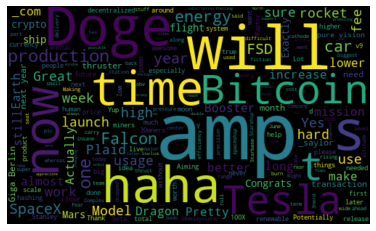

In [66]:
# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df

'''
Let's see how well the sentiments are distributed. 
A good way to accomplish this task is by understanding the common words by plotting word clouds.
A word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word 
appears in text, the bigger and bolder it appears in the word cloud.
Let’s visualize all the words in the data using the word cloud plot.
'''

allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [68]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
 if score < 0:
  return 'Negative'
 elif score == 0:
  return 'Neutral'
 else:
  return 'Positive'


df['Analysis'] = df['Polarity'].apply(getAnalysis)

# Show the dataframe
df

,Tweets,Subjectivity,Polarity,Analysis
0,Needs laser eyes too,0.0,0.000000,Neutral
1,🤣🤣,0.0,0.000000,Neutral
2,Bitcoin 💔,0.0,0.000000,Neutral
3,_feed 🤣🤣,0.0,0.000000,Neutral
4,: Webcast of Falcon 9 launch of Dragon is now ...,0.5,0.136364,Positive
...,...,...,...,...
195,Guest starring …,0.0,0.000000,Neutral
196,,0.0,0.000000,Neutral
197,Will use this as my wallpaper,0.0,0.000000,Neutral
198,: ELON MUSK. MILEY CYRUS.\nTHIS SATURDAY,0.0,0.000000,Neutral


In [69]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+ sortedDF['Tweets'][i])
    print()
    j= j+1

Printing positive tweets:

1) : Webcast of Falcon 9 launch of Dragon is now live →  

2) : Beginning early next year, SpaceX will carry four _Space crews to and from the _station →  h…

3)  That’s where we get most of our lithium. Also, whereas phone batteries make heavy use of cobalt in cathode, Tesla uses primarily nickel, which is trickier, but has better energy density (range).

Iron cathode cells are now competitive for stationary packs &amp; mid range cars.

4) _ferragu Our biggest challenge is supply chain, especially microcontroller chips. Never seen anything like it. 

Fear of running out is causing every company to overorder – like the toilet paper shortage, but at epic scale.

That said, it’s obv not a long-term issue.

5)  Baby Shark crushes all! More views than humans. 

6)  Sounds kinda fun

7) 1 Yeah, new Model S &amp; X have PS5 level entertainment computing power

8)  Nice

9) 3Owners Making this work has been / still is super difficult, but it’s a revolution in car bo

In [70]:

# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['Tweets'][i])
    print()
    j=j+1

Printing negative tweets:

1)  Thanks :) Seriously, it was so insane! Fud still happening a little, but doesn’t resonate when enough people have the product.

2)  Things get weird at the driver level

3) : Falcon 9 and Dragon roll out to Launch Complex 39A ahead of Dragon's 22nd cargo resupply mission to the _Station 

4) 3nerd  Moving lumbar was removed only in front passenger seat of 3/Y (obv not there in rear seats). Logs showed almost no usage. Not worth cost/mass for everyone when almost never used.

Prices increasing due to major supply chain price pressure industry-wide. Raw materials especially.

5)      Actually, so-called “secondary” structure is the hard part – so many pipes &amp; wires. 

Tall stuff &amp; small stuff are the toughest things about Starship.

6)   Dark Helmet emotes Plaid well

7)  Congrats Boring Company team!

8) _    Sick burn haha. Hopefully, next year.

9)  Exactly. Atmospheric drag clearing out orbital debris is a major reason why we dropped altitude to

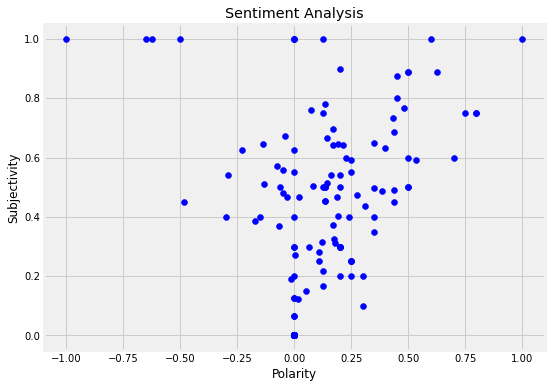

In [71]:
# Plotting
plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
 plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='Blue') # plt.scatter(x,y,color)
 
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [72]:
# Print the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweets

round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)

39.5

In [73]:
# Print the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweets

round( (ntweets.shape[0] / df.shape[0]) * 100, 1)

10.0

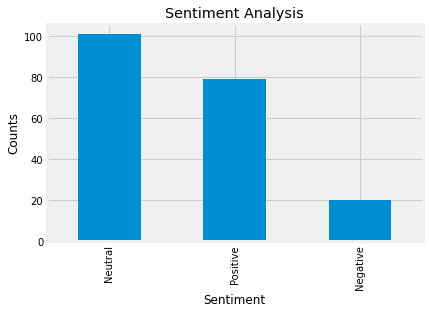

In [74]:
# Show the value counts
df['Analysis'].value_counts()

# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Perform Random Forest Analysis for Classification:

In [113]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [114]:
# Define features set
X = all_sig.copy()
X.drop("close", axis=1, inplace=True)
X.head()

,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band
date,,,,,,,,
2019-09-26,10251.626,10536.073,0.0,0.0,9935.230,713.060753,10648.290753,9222.169247
2019-09-27,10175.894,10525.262,0.0,0.0,9820.860,798.797709,10619.657709,9022.062291
2019-09-28,10103.012,10512.054,0.0,0.0,9711.105,862.088116,10573.193116,8849.016884
2019-09-29,10038.380,10490.393,0.0,0.0,9598.035,924.802142,10522.837142,8673.232858
2019-09-30,9974.046,10466.855,0.0,0.0,9508.810,959.804138,10468.614138,8549.005862


In [115]:
# Define target vector
y = all_sig["close"].ravel()
y[:5]

array(['8060.3', '8196.0', '8213.5', '8053.1', '8310.0'], dtype=object)

In [116]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [117]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [118]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [119]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [120]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

In [121]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [122]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [126]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(465, 8) (156, 8)
(465,) (156,)


In [123]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

ValueError: Shape of passed values is (279, 279), indices imply (2, 2)